# **Diversification Analysis**

In [256]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import yfinance as yf

import warnings
from scipy.optimize import minimize
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## Step 1: Load & Explore the Data

In [259]:
sp500_companies = pd.read_csv('sp500_companies.csv')
sp500_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


In [261]:
sp500_index = pd.read_csv('sp500_index.csv')
sp500_index.head()

,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


In [263]:
sp500_stocks = pd.read_csv('sp500_stocks.csv')
sp500_stocks = sp500_stocks.dropna().reset_index(drop=True)
sp500_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,AOS,5.937266,7.435000,7.480000,7.261667,7.295000,1104600.0
1,2010-01-05,AOS,5.861404,7.340000,7.431667,7.308333,7.431667,1207200.0
2,2010-01-06,AOS,5.864068,7.343333,7.405000,7.301667,7.335000,663000.0
3,2010-01-07,AOS,5.881369,7.365000,7.425000,7.311667,7.356667,564000.0
4,2010-01-08,AOS,5.967879,7.473333,7.485000,7.311667,7.331667,504600.0


Missing Values

In [265]:
display(sp500_stocks.isna().sum())
print()
display(sp500_index.isna().sum())
print()
display(sp500_companies.isna().sum())

Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Date      0
S&P500    0
dtype: int64

Exchange                0
Symbol                  0
Shortname               0
Longname                0
Sector                  0
Industry                0
Currentprice            0
Marketcap               0
Ebitda                 29
Revenuegrowth           3
City                    0
State                  20
Country                 0
Fulltimeemployees       9
Longbusinesssummary     0
Weight                  0
dtype: int64

States is not really important to us so we will just drop it and focus on country.

In [270]:
sp500_companies = sp500_companies.drop(['State'], axis=1)
sp500_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


Missing Revenue Growth

In [273]:
sp500_companies[sp500_companies['Revenuegrowth'].isnull()].head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Fulltimeemployees,Longbusinesssummary,Weight
55,NYQ,VZ,Verizon Communications Inc.,Verizon Communications Inc.,Communication Services,Telecom Services,39.93,168090517504,4.842900e+10,NaN,New York,United States,101200.0,"Verizon Communications Inc., through its subsi...",0.003024
109,NYQ,AMT,American Tower Corporation (REI,American Tower Corporation,Real Estate,REIT - Specialty,183.73,85855002624,6.966100e+09,NaN,Boston,United States,5643.0,"American Tower, one of the largest global REIT...",0.001545
359,NMS,WDC,Western Digital Corporation,Western Digital Corporation,Technology,Computer Hardware,60.24,20825450496,2.134000e+09,NaN,San Jose,United States,51000.0,"Western Digital Corporation develops, manufact...",0.000375


We can try to look on yahoo finance to impute some of these missing values. Upon closer inspection, the companies with missing EBITDA are all banks which do not report EBITDA numbers. 

In [276]:
def replace_null(df, sym, col, missing):
    ticker = yf.Ticker(sym.lower())
    info = ticker.info  # Fetch ticker info once
    
    if missing in info:  # Check if the key exists
        df.loc[df['Symbol'] == sym, col] = info[missing]
        print(f'found {sym} \n')
    else:
        print(f"Warning: {missing} not found for {sym}")  # Log missing values

missing_revenues = []
missing_employees = []

for symbol in sp500_companies[sp500_companies['Revenuegrowth'].isnull()]['Symbol']:
    replace_null(sp500_companies, symbol, 'Revenuegrowth', 'revenueGrowth')
    missing_revenues.append(symbol)

print("Symbols with missing revenueGrowth:", missing_revenues , '\n')

for symbol in sp500_companies[sp500_companies['Fulltimeemployees'].isnull()]['Symbol']:
    replace_null(sp500_companies, symbol, 'Fulltimeemployees', 'fullTimeEmployees')  
    missing_employees.append(symbol)

print('Symbols with missing Full time employees:', missing_employees)

Symbols with missing revenueGrowth: ['VZ', 'AMT', 'WDC'] 

Symbols with missing Full time employees: ['V', 'SBUX', 'DHI', 'RMD', 'RJF', 'SMCI', 'FFIV', 'SOLV', 'AMTM']


It seems like these values are not found on yahoo finance either. These are not critical fields for our analysis so it is fine to just leave them as is. 

## Data Exploration and Visualization

Of course, we have the classic sp 500 all time graph. missing value from before 2014

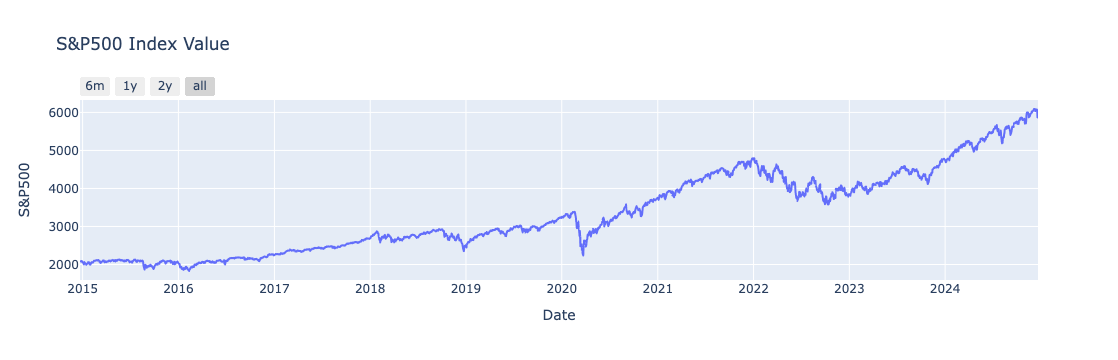

In [280]:
fig = px.line(sp500_index, x=sp500_index["Date"], y=sp500_index["S&P500"], title='S&P500 Index Value')

fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1,col=1)

fig.show()

<Figure size 1500x1200 with 0 Axes>

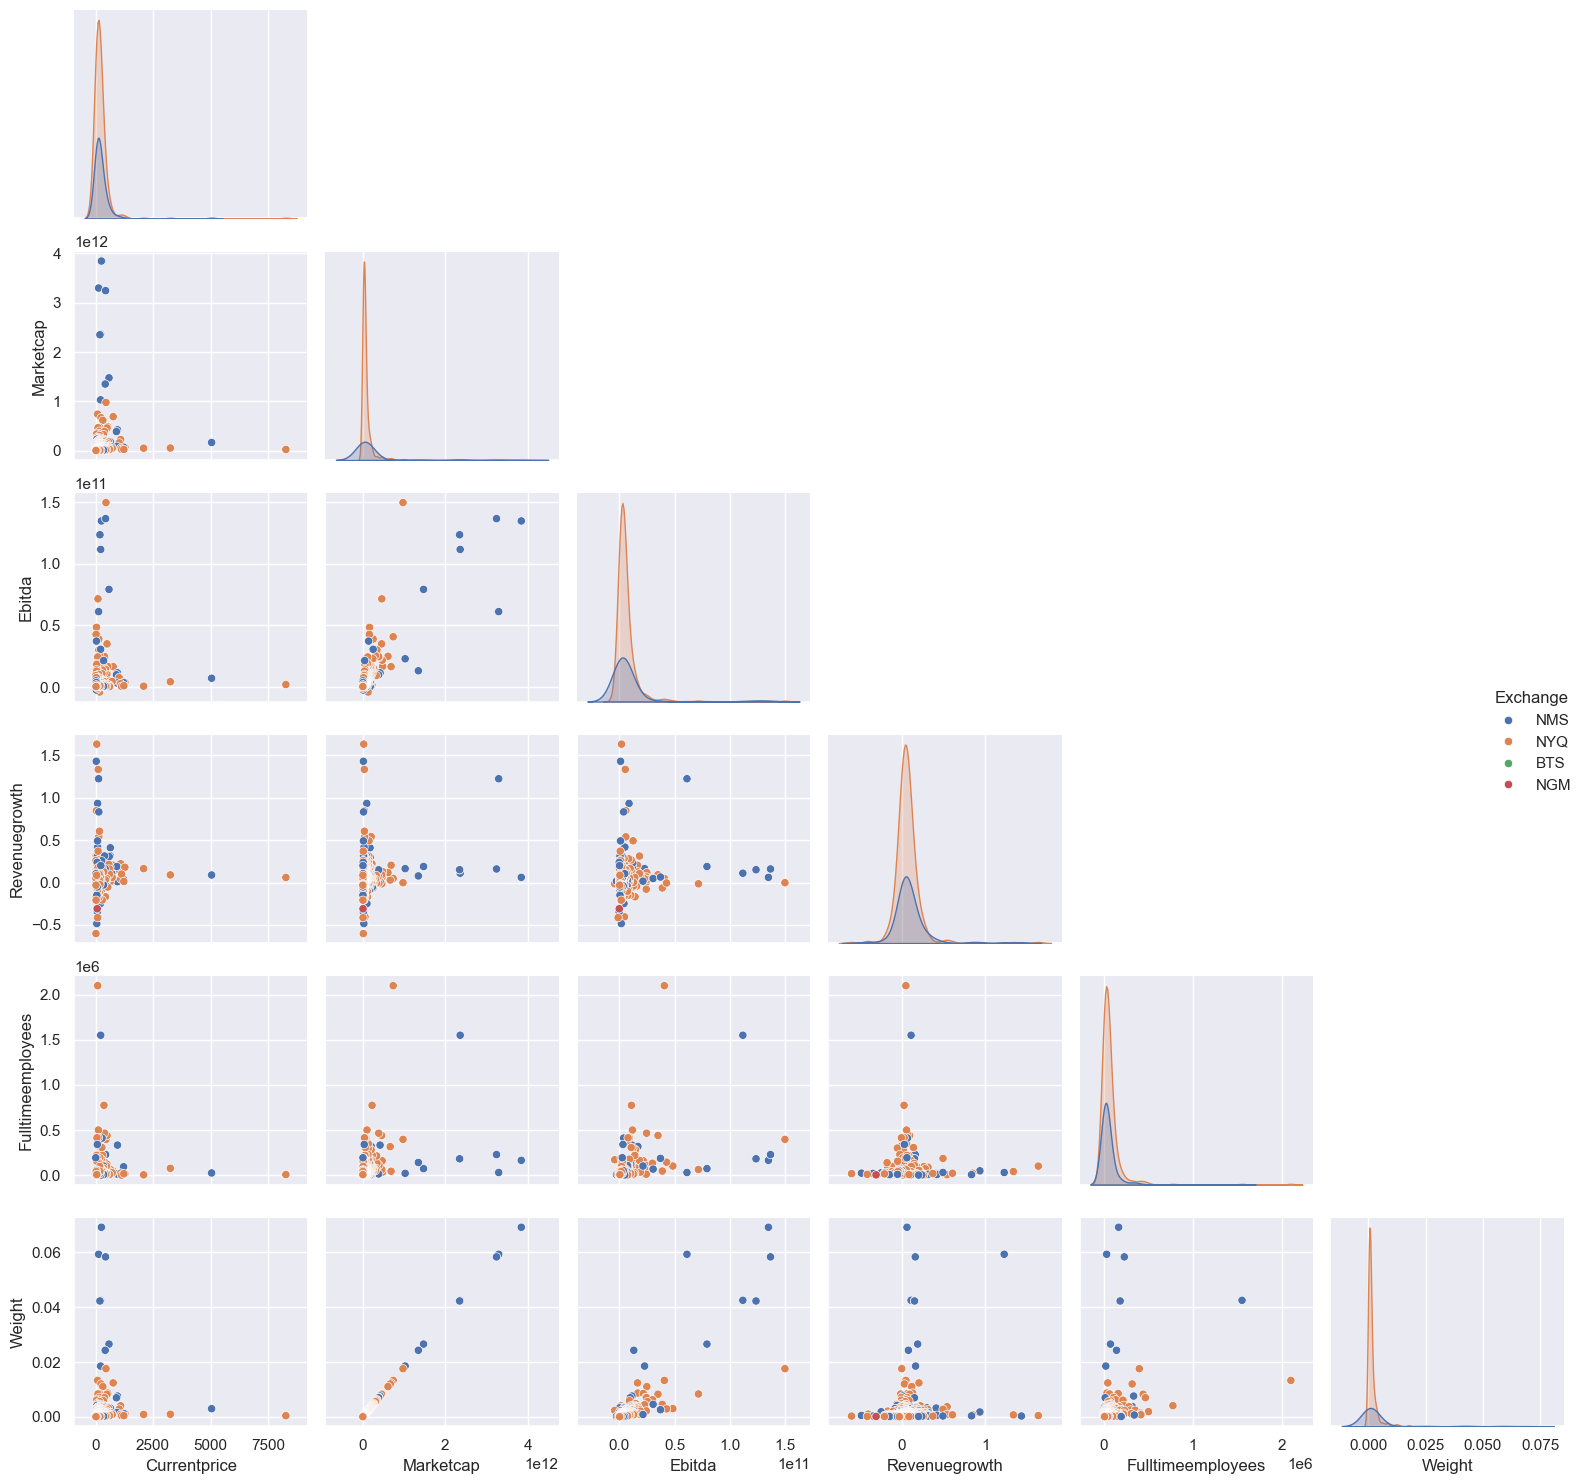

In [281]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,12))
sns.pairplot(sp500_companies, corner=True, hue='Exchange')
plt.tight_layout()

Write something here about what the graph above means lol

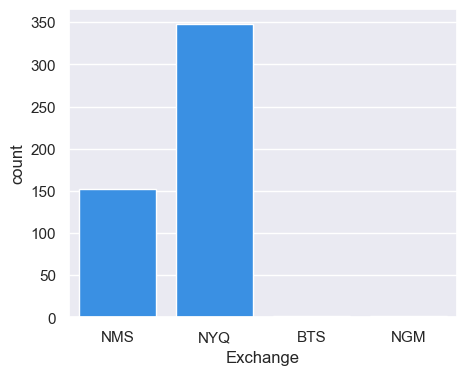

In [283]:
plt.figure(figsize=(5,4))
d0 = sns.countplot(data=sp500_companies, x='Exchange', color='dodgerblue') 

From the graph, it seems like the vast majority of exchanges our stocks are traded on is the National Market System (NMS) and New York Stock Exchange (NYQ).

(-0.7, 3.0)

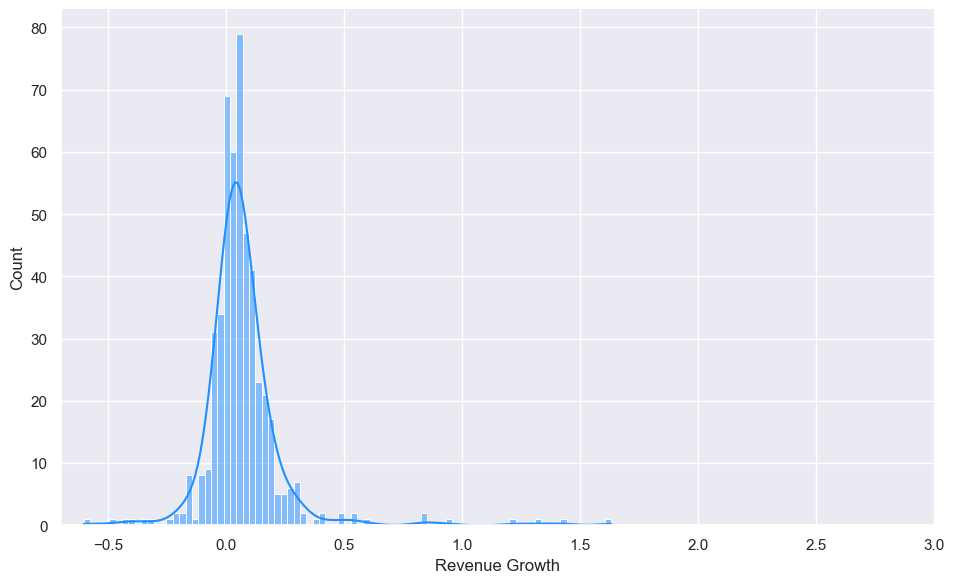

In [287]:
d1 = sns.displot(data=sp500_companies, x='Revenuegrowth', height=6, aspect=1.6, kde=True, color='dodgerblue')
d1.set(xlabel='Revenue Growth')
plt.xlim(-0.7,3)

(0.0, 1500.0)

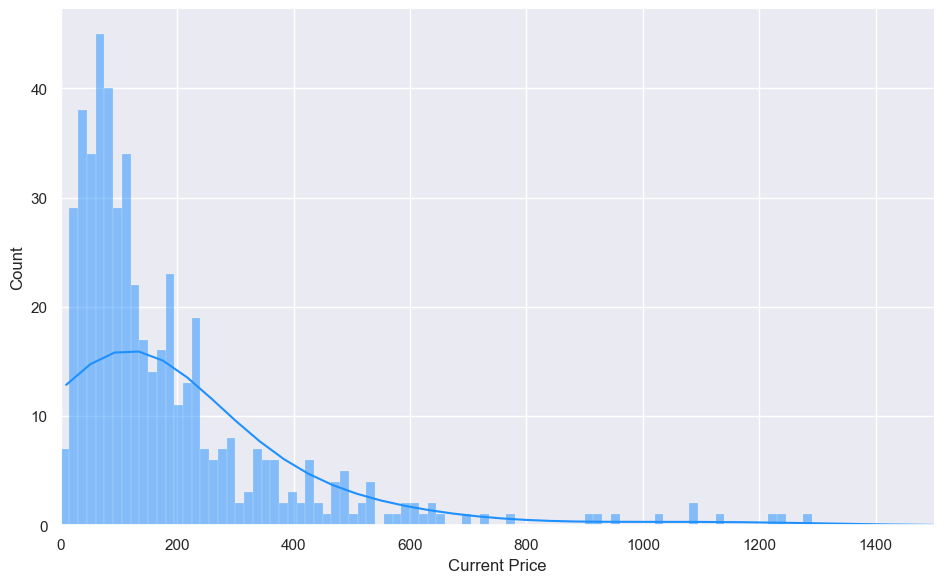

In [289]:
d2 = sns.displot(data=sp500_companies, x='Currentprice', kde=True, height=6, aspect=1.6, bins=100, binrange=(0, 1500), color='dodgerblue')
d2.set(xlabel='Current Price')
plt.xlim(0, 1500)

In [291]:
print(f'The mode of the Current Price column is {sp500_companies.Currentprice.mode()[0]}.')

The mode of the Current Price column is 88.95.


Leading Sectors:

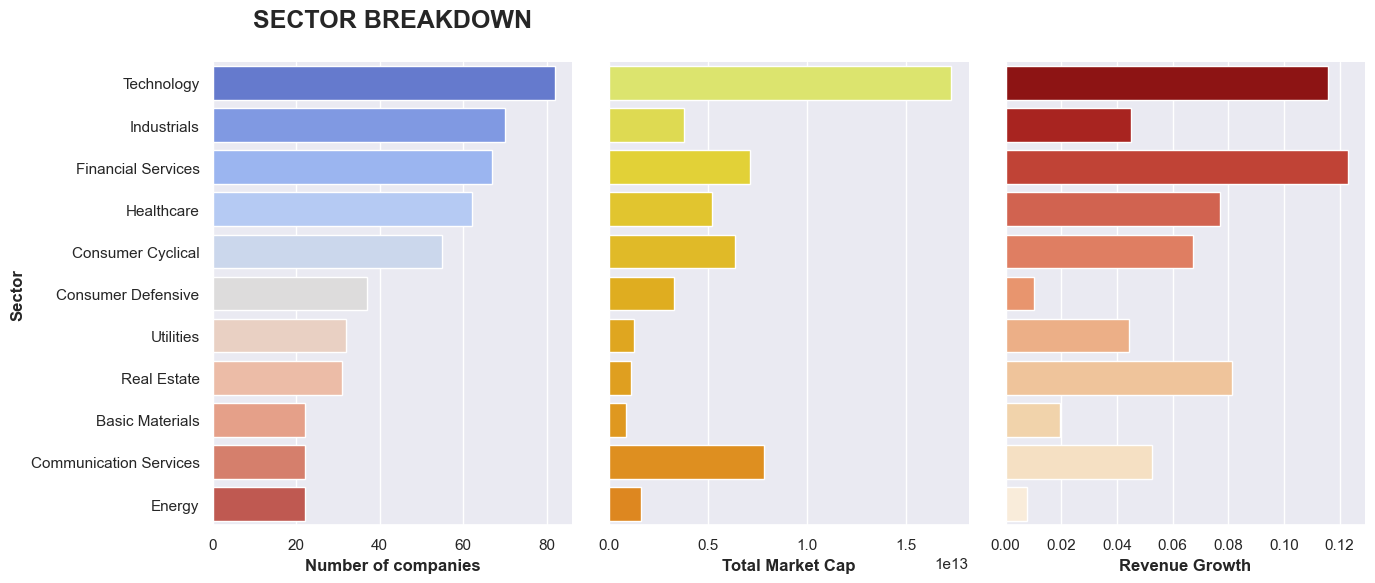

In [298]:
f = {'Revenuegrowth':['mean'], 'Marketcap':['sum'], 'Longname':['count']}

sector_breakdown = sp500_companies.groupby('Sector').agg(f)
sector_breakdown.columns = sector_breakdown.columns.get_level_values(0)
sector_breakdown = sector_breakdown.reset_index()
sector_breakdown = sector_breakdown.sort_values('Longname', ascending=False)

fig = plt.figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="Longname", y="Sector", data=sector_breakdown, palette=('coolwarm'))
ax1.set_xlabel('Number of companies', weight='bold')
ax1.set_ylabel('Sector', weight = 'bold')
ax1.set_title('SECTOR BREAKDOWN\n', weight='bold').set_fontsize('18')

plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="Marketcap", y="Sector", data=sector_breakdown, palette=('Wistia'))
ax2.set_xlabel('Total Market Cap', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 3, 3)
ax2 = sns.barplot(x="Revenuegrowth", y="Sector", data=sector_breakdown, palette=('OrRd_r'))
ax2.set_xlabel('Revenue Growth', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();

Stock Exchanges:

In [301]:
sp500_companies[sp500_companies['Exchange'] == 'BTS']

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Fulltimeemployees,Longbusinesssummary,Weight
368,BTS,CBOE,"Cboe Global Markets, Inc.","Cboe Global Markets, Inc.",Financial Services,Financial Data & Stock Exchanges,191.61,20058884096,1.290400e+09,0.162,Chicago,United States,1647.0,"Cboe Global Markets, Inc., through its subsidi...",0.000361


In [303]:
sp500_companies[sp500_companies['Exchange'] == 'NGM']

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Fulltimeemployees,Longbusinesssummary,Weight
476,NGM,ENPH,"Enphase Energy, Inc.","Enphase Energy, Inc.",Technology,Solar,71.45,9653395456,102900000.0,-0.309,Fremont,United States,3157.0,"Enphase Energy, Inc., together with its subsid...",0.000174


Top 12 companies

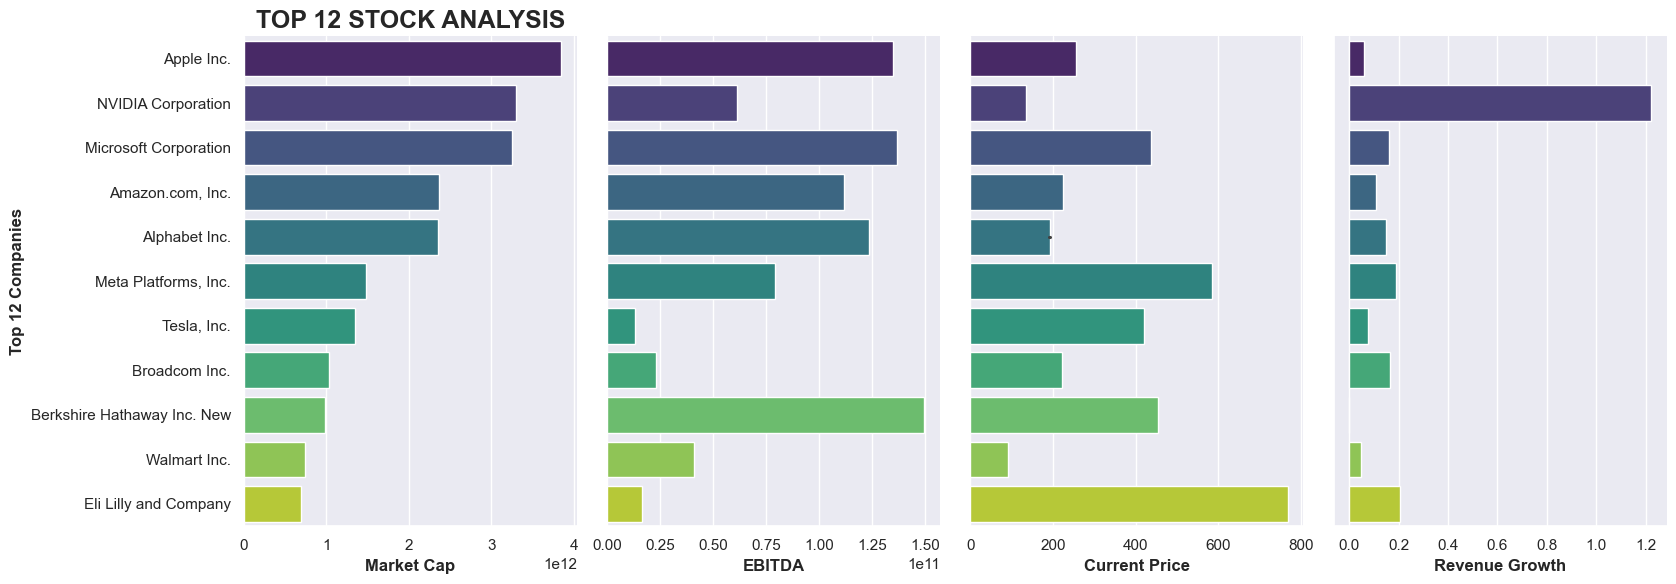

In [306]:
N = 12
fig2 = plt.figure(num=None, figsize=(17, 6), dpi=100, facecolor='w', edgecolor='k')
palette_name = 'viridis'

plt.subplot(1, 4, 1)
ax1 = sns.barplot(x=sp500_companies.iloc[:N,7], y=sp500_companies.iloc[:N,2], data=sp500_companies, palette=(palette_name))
ax1.set_xlabel('Market Cap', weight='bold')
ax1.set_ylabel(f'Top {N} Companies', weight = 'bold')
ax1.set_title(f'TOP {N} STOCK ANALYSIS', weight='bold').set_fontsize('18')

plt.subplot(1, 4, 2)
ax2 = sns.barplot(x=sp500_companies.iloc[:N,8], y=sp500_companies.iloc[:N,2], data=sp500_companies, palette=(palette_name))
ax2.set_xlabel('EBITDA', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 4, 3)
ax2 = sns.barplot(x=sp500_companies.iloc[:N,6], y=sp500_companies.iloc[:N,2], data=sp500_companies, palette=(palette_name))
ax2.set_xlabel('Current Price', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 4, 4)
ax2 = sns.barplot(x=sp500_companies.iloc[:N,9], y=sp500_companies.iloc[:N,2], data=sp500_companies, palette=(palette_name))
ax2.set_xlabel('Revenue Growth', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();


In [307]:
sp500_companies['Sector'].unique()

array(['Technology', 'Consumer Cyclical', 'Communication Services',
       'Financial Services', 'Consumer Defensive', 'Healthcare', 'Energy',
       'Basic Materials', 'Industrials', 'Utilities', 'Real Estate'],
      dtype=object)

In [310]:
non_us = sp500_companies[sp500_companies['Country'] != 'United States']['Shortname'].count()
us = sp500_companies[sp500_companies['Country'] == 'United States']['Shortname'].count()
print(f'Number of non US companies: {non_us}')
print(f'Number of US companies: {us}')

Number of non US companies: 21
Number of US companies: 481


## Diversification Tests

In [314]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

sp500_index = sp500_index.sort_values('Date')
sp500_stocks = sp500_stocks.sort_values(['Symbol', 'Date'])

sp500_index['Log_Returns'] = np.log(sp500_index['S&P500'] / sp500_index['S&P500'].shift(1))
sp500_stocks['Log_Returns'] = sp500_stocks.groupby('Symbol')['Adj Close'].transform(lambda x: np.log(x / x.shift(1)))

print(sp500_index[['Date', 'S&P500', 'Log_Returns']].head())
print(sp500_stocks[['Date', 'Symbol', 'Adj Close', 'Log_Returns']].head())

        Date   S&P500  Log_Returns
0 2014-12-22  2078.54          NaN
1 2014-12-23  2082.17     0.001745
2 2014-12-24  2081.88    -0.000139
3 2014-12-26  2088.77     0.003304
4 2014-12-29  2090.57     0.000861
           Date Symbol  Adj Close  Log_Returns
7536 2013-01-02   ABBV  21.629181          NaN
7537 2013-01-03   ABBV  21.450581    -0.008292
7538 2013-01-04   ABBV  21.179594    -0.012714
7539 2013-01-07   ABBV  21.222700     0.002033
7540 2013-01-08   ABBV  20.760809    -0.022004


We will test this by constructing different portfolios

### Portolio 1: Concentrated Portfolio (Top 10 by Market Cap)

In [319]:
top_10_stocks = sp500_companies.nlargest(10, 'Marketcap')
top_10_prices = sp500_stocks[sp500_stocks['Symbol'].isin(top_10_stocks['Symbol'])]
top_10_prices.loc[:, 'Log_Returns'] = top_10_prices.groupby('Symbol')['Adj Close'].transform(lambda x: np.log(x / x.shift(1)))
top_10_weights = {symbol: 1/10 for symbol in top_10_stocks['Symbol']}
top_10_weights

{'AAPL': 0.1,
 'NVDA': 0.1,
 'MSFT': 0.1,
 'AMZN': 0.1,
 'GOOGL': 0.1,
 'GOOG': 0.1,
 'META': 0.1,
 'TSLA': 0.1,
 'AVGO': 0.1,
 'BRK-B': 0.1}

### Portfolio 2: Equally Weighted Portfolio

In [371]:
# Get all unique symbols
all_symbols = sp500_companies['Symbol'].unique()

# Merge with stock price data
all_stock_prices = sp500_stocks[sp500_stocks['Symbol'].isin(all_symbols)]

# Compute log returns
all_stock_prices['Log_Returns'] = all_stock_prices.groupby('Symbol')['Adj Close'].transform(lambda x: np.log(x / x.shift(1)))

# Equal weights for all stocks
equal_weights = {symbol: 1/len(all_symbols) for symbol in all_symbols}

### Portfolio 3: Sector Diversified Portfolio

In [449]:
# Step 1: Compute sector weights (equal allocation among sectors)
sector_weights = {sector: 1 / len(sp500_companies['Sector'].unique()) for sector in sp500_companies['Sector'].unique()}

# Step 2: Assign sector weights to companies
sp500_companies['Sector_Weight'] = sp500_companies['Sector'].map(sector_weights)

# Step 3: Calculate total market cap per sector
sector_total_market_cap = sp500_companies.groupby('Sector')['Marketcap'].sum()

# Step 4: Compute stock-specific weights within sectors based on market cap
sp500_companies['Stock_Weight'] = sp500_companies.apply(
    lambda row: (row['Marketcap'] / sector_total_market_cap[row['Sector']]) * row['Sector_Weight'], axis=1
)

# Step 5: Convert to a dictionary with stock tickers as keys and stock weights as values
sector_weights = dict(zip(sp500_companies['Symbol'], sp500_companies['Stock_Weight']))

### Portfolio 4: Market Cap Weighted Portfolio

In [363]:
# Compute total market capitalization
total_market_cap = sp500_companies['Marketcap'].sum()

# Assign market cap weights
sp500_companies['Market_Cap_Weight'] = sp500_companies['Marketcap'] / total_market_cap

# Merge market cap weights with stock price data
market_cap_prices = sp500_stocks.merge(sp500_companies[['Symbol', 'Market_Cap_Weight']], on='Symbol', how='left')

# Apply weights to log returns
market_cap_prices['Weighted_Return'] = market_cap_prices['Log_Returns'] * market_cap_prices['Market_Cap_Weight']
market_cap_weights = dict(zip(sp500_companies['Symbol'], sp500_companies['Marketcap'] / total_market_cap))

### Portfolio 5: Risk Parity Portfolio

In [353]:
# Compute rolling volatility (252-day for annualized volatility)
volatility = sp500_stocks.groupby('Symbol')['Log_Returns'].std()

# Compute inverse volatility weights
inv_vol_weights = 1 / volatility
inv_vol_weights /= inv_vol_weights.sum()  # Normalize to sum to 1

# Merge with stock data
risk_parity_prices = sp500_stocks.merge(inv_vol_weights.rename('Inv_Vol_Weight'), on='Symbol', how='left')

# Apply weight to returns
risk_parity_prices['Weighted_Return'] = risk_parity_prices['Log_Returns'] * risk_parity_prices['Inv_Vol_Weight']
inv_vol_weights

Symbol
ABBV    0.006292
ABT     0.007775
ADM     0.006362
AES     0.005214
AJG     0.008175
          ...   
WMB     0.004398
WRB     0.007593
WST     0.005996
WTW     0.007451
XYL     0.006338
Name: Log_Returns, Length: 172, dtype: float64

In [406]:
portfolios = [top_10_weights, equal_weights, sector_weights, market_cap_weights, inv_vol_weights]

In [435]:
def monte_carlo_portfolio_simulation(weights_dict, sp500_stocks, num_simulations=1000, num_days=252):
    """
    Performs Monte Carlo simulation for a portfolio based on stock weights.

    Parameters:
        weights_dict (dict): Dictionary with stock tickers as keys and weights as values.
        sp500_stocks (pd.DataFrame): DataFrame containing at least columns ['Symbol', 'Date', 'Adj Close'].
        num_simulations (int, optional): Number of Monte Carlo simulations. Default is 1,000.
        num_days (int, optional): Number of trading days (default is 252 for one year).

    Returns:
        stats (dict): A dictionary containing key statistics:
            {
                'Expected Final Value': float,
                'Standard Deviation': float,
                'Value at Risk (VaR 95%)': float,
                'Sharpe Ratio': float,
                'Maximum Drawdown': float
            }
        fig1 (plt.Figure): Line plot of Monte Carlo simulations.
        fig2 (plt.Figure): Histogram of final portfolio values.
    """

    # Ensure selected stocks are in the dataset
    selected_stocks = sp500_stocks[sp500_stocks['Symbol'].isin(weights_dict.keys())]

    # Pivot to get adjusted close prices with dates as index
    selected_stocks_pivot = selected_stocks.pivot(index='Date', columns='Symbol', values='Adj Close')

    # Convert date column to datetime
    selected_stocks_pivot.index = pd.to_datetime(selected_stocks_pivot.index)

    # Calculate daily log returns
    log_returns = np.log(selected_stocks_pivot / selected_stocks_pivot.shift(1)).dropna()

    # Ensure all stocks in weights are in the log returns DataFrame
    valid_stocks = [stock for stock in weights_dict.keys() if stock in log_returns.columns]
    weights = np.array([weights_dict[stock] for stock in valid_stocks])

    # Compute mean returns and covariance matrix for valid stocks
    mean_returns = log_returns[valid_stocks].mean()
    cov_matrix = log_returns[valid_stocks].cov()

    # Monte Carlo Simulation
    simulated_portfolios = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        # Simulate random daily returns
        simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        
        # Compute cumulative returns for each stock
        simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=0)
        
        # Compute portfolio cumulative return (dot product of each day's returns with the weights)
        simulated_portfolio_value = np.dot(simulated_cumulative_returns, weights)
        
        simulated_portfolios[i, :] = simulated_portfolio_value

    # Compute Monte Carlo statistics
    final_portfolio_values = simulated_portfolios[:, -1]
    expected_final_value = np.mean(final_portfolio_values)
    std_dev_final_value = np.std(final_portfolio_values)
    VaR_95 = np.percentile(final_portfolio_values, 5)  # 5% worst-case scenario
    Sharpe_ratio = (expected_final_value - 1) / std_dev_final_value  # Assuming risk-free rate = 0
    # Calculate max drawdown across all simulations
    max_drawdown = np.min(
        simulated_portfolios / np.maximum.accumulate(simulated_portfolios, axis=1) - 1
    )

    # Store results in a dictionary
    stats = {
        "Expected Final Value": expected_final_value,
        "Standard Deviation": std_dev_final_value,
        "Value at Risk (VaR 95%)": VaR_95,
        "Sharpe Ratio": Sharpe_ratio,
        "Maximum Drawdown": max_drawdown
    }

    # Create the simulation plot (fig1)
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(simulated_portfolios.T, color='blue', alpha=0.1)
    ax1.axhline(expected_final_value, color='red', linestyle='dashed', 
                label=f'Expected Value: {expected_final_value:.2f}')
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Monte Carlo Simulations of Portfolio Performance")
    ax1.legend()

    # Create the histogram of final portfolio values (fig2)
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.hist(final_portfolio_values, bins=50, color='blue', alpha=0.7)
    ax2.axvline(expected_final_value, color='red', linestyle='dashed',
                label=f'Expected Value: {expected_final_value:.2f}')
    ax2.axvline(VaR_95, color='black', linestyle='dashed',
                label=f'VaR 95%: {VaR_95:.2f}')
    ax2.set_xlabel("Final Portfolio Value")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Portfolio Values at Year End")
    ax2.legend()

    # Return stats and figure objects without showing them
    return stats, fig1, fig2

In [454]:
# monte_carlo_portfolio_simulation(sector_weights, sp500_stocks)

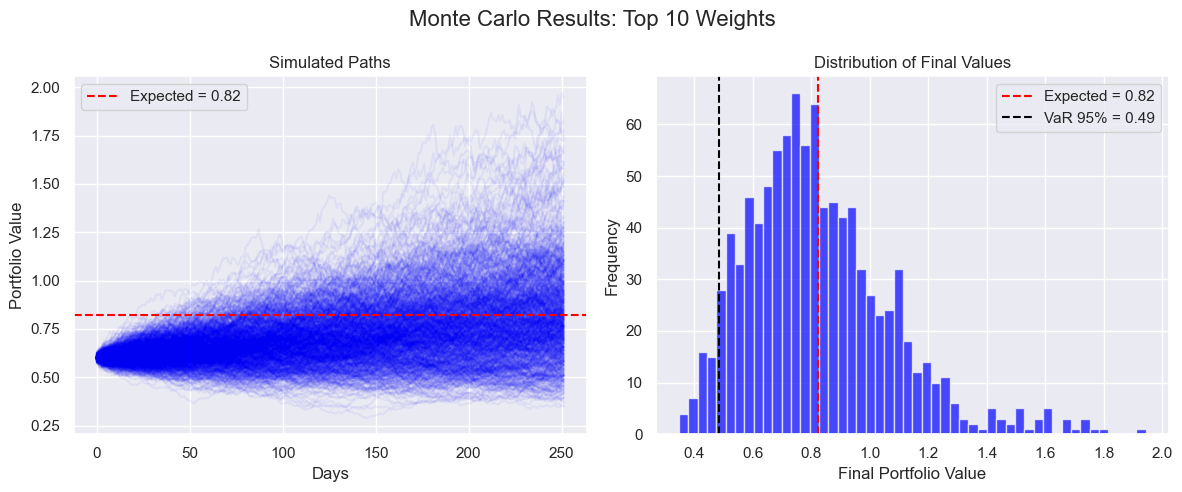

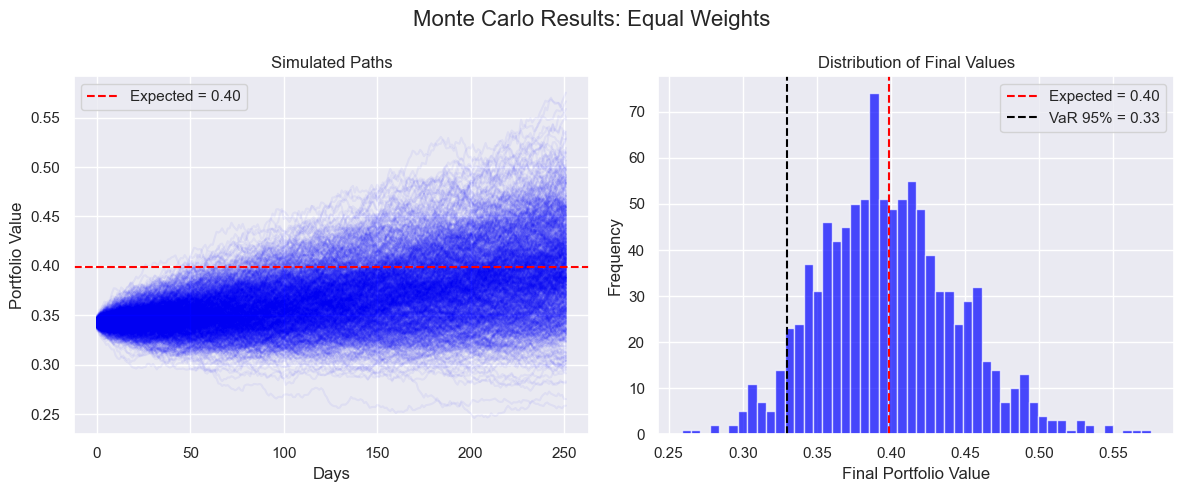

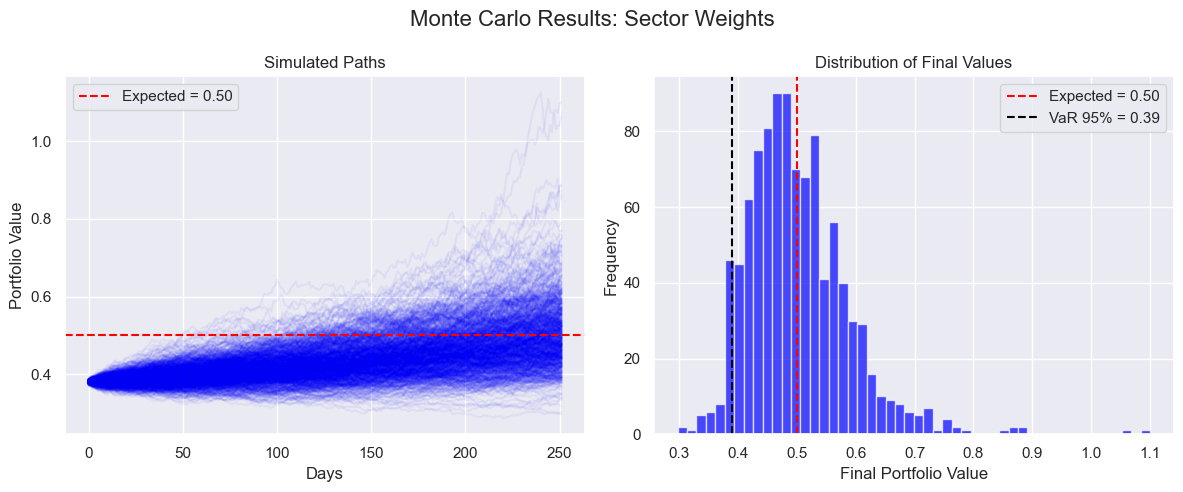

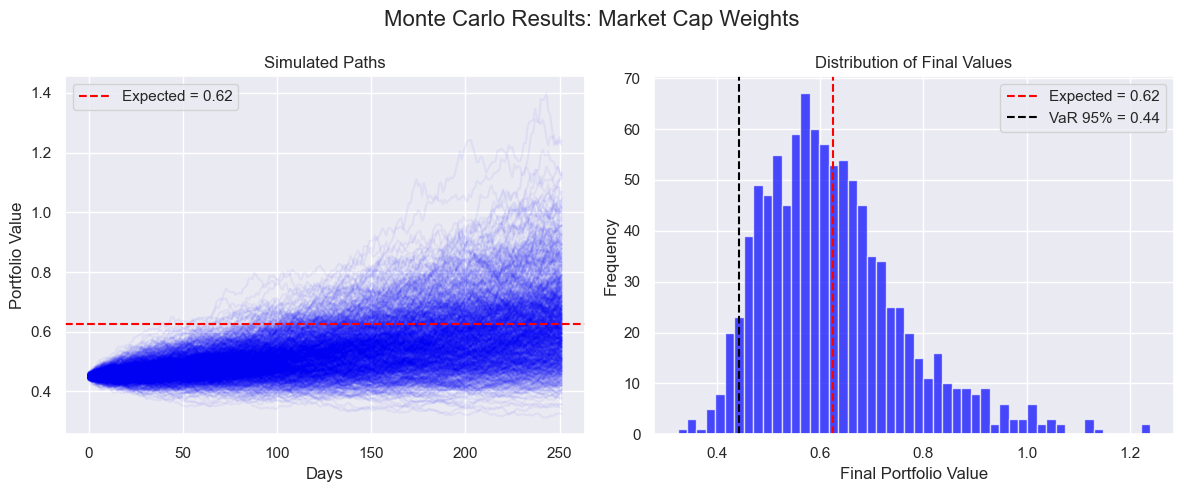

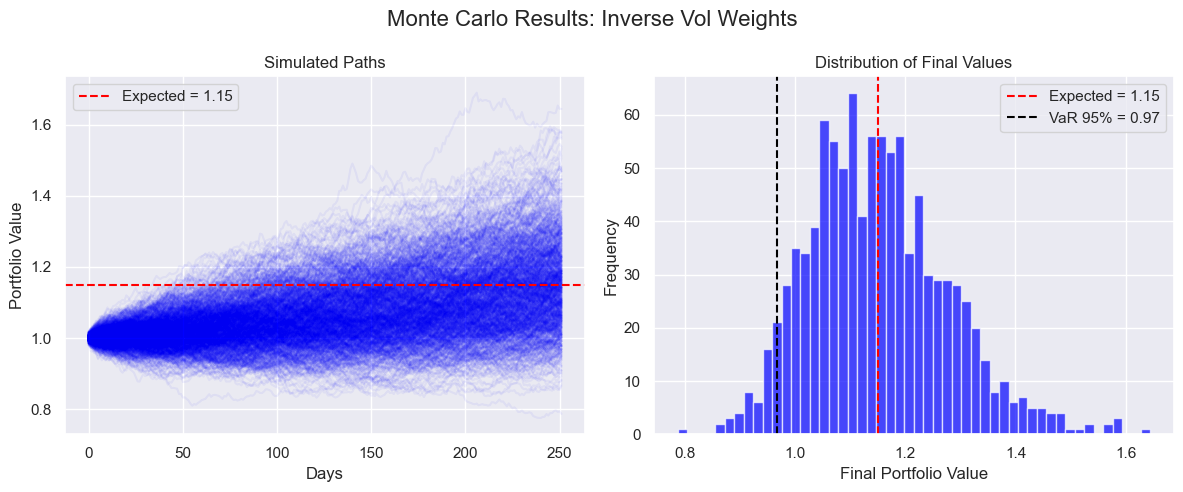

             Portfolio  Expected Final Value   Std Dev   VaR 95%  \
0       Top 10 Weights              0.822892  0.250301  0.486229   
1        Equal Weights              0.398569  0.046694  0.329865   
2       Sector Weights              0.500809  0.086523  0.389515   
3   Market Cap Weights              0.624993  0.137055  0.444247   
4  Inverse Vol Weights              1.149769  0.125674  0.966862   

   Sharpe Ratio  Max Drawdown  
0     -0.707579     -0.523257  
1    -12.880358     -0.287991  
2     -5.769460     -0.267692  
3     -2.736176     -0.338502  
4      1.191729     -0.252022  


In [456]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Example data setup (replace with your actual data/weights)
# =============================================================================
# sp500_stocks must have at least ['Date', 'Symbol', 'Adj Close']
# For example:
# sp500_stocks = pd.read_csv("sp500_data.csv")

# Example weight dictionaries (replace with your actual ones):
# top_10_weights       = {'AAPL': 0.1, 'MSFT': 0.1, ... } # total must be 1
# equal_weights        = {'AAPL': 0.2, 'MSFT': 0.2, ... }
# sector_weights       = ...
# market_cap_weights   = ...
# inv_vol_weights      = ...

# Your list of portfolios:
portfolios = [
    top_10_weights,
    equal_weights,
    sector_weights,
    market_cap_weights,
    inv_vol_weights
]

portfolio_names = [
    "Top 10 Weights", 
    "Equal Weights", 
    "Sector Weights", 
    "Market Cap Weights", 
    "Inverse Vol Weights"
]

# =============================================================================
# Parameters for the Monte Carlo simulation
# =============================================================================
num_simulations = 1000
num_days = 252  # typically 252 trading days in a year

# =============================================================================
# Prepare a list to store the statistics for each portfolio
# =============================================================================
stats_list = []

# =============================================================================
# Loop over each portfolio, run the Monte Carlo simulation, store stats, and plot
# =============================================================================
for portfolio_name, weights_dict in zip(portfolio_names, portfolios):
    # ------------------------------------------------
    # 1. Filter the sp500_stocks for the portfolio
    # ------------------------------------------------
    selected_stocks = sp500_stocks[sp500_stocks['Symbol'].isin(weights_dict.keys())]

    # Pivot so that each column is a Symbol, rows are Dates, values are 'Adj Close'
    selected_stocks_pivot = selected_stocks.pivot(index='Date', columns='Symbol', values='Adj Close')
    
    # Convert index to datetime
    selected_stocks_pivot.index = pd.to_datetime(selected_stocks_pivot.index)
    
    # ------------------------------------------------
    # 2. Calculate daily log returns
    # ------------------------------------------------
    log_returns = np.log(selected_stocks_pivot / selected_stocks_pivot.shift(1)).dropna()
    
    # Make sure the stocks in the weights dict are actually in our data
    valid_stocks = [s for s in weights_dict.keys() if s in log_returns.columns]
    weights = np.array([weights_dict[s] for s in valid_stocks])
    
    # ------------------------------------------------
    # 3. Compute mean returns and covariance matrix
    # ------------------------------------------------
    mean_returns = log_returns[valid_stocks].mean()
    cov_matrix = log_returns[valid_stocks].cov()
    
    # ------------------------------------------------
    # 4. Monte Carlo simulation
    # ------------------------------------------------
    simulated_portfolios = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        # Random draws from a multivariate normal
        simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        # Cumulative returns per stock
        sim_cum_returns = np.cumprod(1 + simulated_daily_returns, axis=0)
        # Portfolio value each day (dot product each day with the weights)
        portfolio_values = np.dot(sim_cum_returns, weights)
        simulated_portfolios[i, :] = portfolio_values

    # ------------------------------------------------
    # 5. Compute statistics
    # ------------------------------------------------
    final_values = simulated_portfolios[:, -1]  # final day for each simulation
    expected_final_value = np.mean(final_values)
    std_dev_final_value = np.std(final_values)
    VaR_95 = np.percentile(final_values, 5)  # 5th percentile
    sharpe_ratio = (expected_final_value - 1) / std_dev_final_value  # risk-free assumed 0

    # Max drawdown across all simulations
    drawdown = simulated_portfolios / np.maximum.accumulate(simulated_portfolios, axis=1) - 1
    max_drawdown = np.min(drawdown)

    # Store in a dict
    portfolio_stats = {
        "Portfolio": portfolio_name,
        "Expected Final Value": expected_final_value,
        "Std Dev": std_dev_final_value,
        "VaR 95%": VaR_95,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }
    stats_list.append(portfolio_stats)

    # ------------------------------------------------
    # 6. Plot results in a 1x2 figure
    # ------------------------------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle(f"Monte Carlo Results: {portfolio_name}", fontsize=16)

    # Left subplot: line plot of simulated paths
    ax_line = axes[0]
    for i in range(num_simulations):
        ax_line.plot(simulated_portfolios[i, :], color='blue', alpha=0.05)
    ax_line.axhline(expected_final_value, color='red', linestyle='--',
                    label=f'Expected = {expected_final_value:.2f}')
    ax_line.set_title("Simulated Paths")
    ax_line.set_xlabel("Days")
    ax_line.set_ylabel("Portfolio Value")
    ax_line.legend()

    # Right subplot: histogram of final values
    ax_hist = axes[1]
    ax_hist.hist(final_values, bins=50, color='blue', alpha=0.7)
    ax_hist.axvline(expected_final_value, color='red', linestyle='--',
                    label=f'Expected = {expected_final_value:.2f}')
    ax_hist.axvline(VaR_95, color='black', linestyle='--',
                    label=f'VaR 95% = {VaR_95:.2f}')
    ax_hist.set_title("Distribution of Final Values")
    ax_hist.set_xlabel("Final Portfolio Value")
    ax_hist.set_ylabel("Frequency")
    ax_hist.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. Create a DataFrame of stats for all portfolios
# =============================================================================
stats_df = pd.DataFrame(stats_list)
stats_df

### Portfolio 6: Momentum Portfolio

In [178]:
# Compute 6-month returns
momentum_returns = sp500_stocks.groupby('Symbol')['Adj Close'].apply(lambda x: x.pct_change(126))

# Select top 20 stocks with highest momentum
top_momentum_stocks = momentum_returns.groupby('Symbol').mean().nlargest(20)

# Merge with stock data
momentum_prices = sp500_stocks[sp500_stocks['Symbol'].isin(top_momentum_stocks.index)]

# Equal weight for selected stocks
momentum_weights = {symbol: 1/20 for symbol in top_momentum_stocks.index}
momentum_weights

{'ENPH': 0.05,
 'TSLA': 0.05,
 'NVDA': 0.05,
 'NFLX': 0.05,
 'AXON': 0.05,
 'VLTO': 0.05,
 'BLDR': 0.05,
 'ANET': 0.05,
 'SOLV': 0.05,
 'META': 0.05,
 'DXCM': 0.05,
 'DELL': 0.05,
 'FTNT': 0.05,
 'LRCX': 0.05,
 'TDG': 0.05,
 'DPZ': 0.05,
 'AMZN': 0.05,
 'HCA': 0.05,
 'PHM': 0.05,
 'TT': 0.05}

### Portfolio 7: Minimum Variance Portfolio

In [54]:
returns_matrix = sp500_stocks.pivot(index='Date', columns='Symbol', values='Log_Returns')
cov_matrix = returns_matrix.cov()  # This is (N, N) where N = number of stocks

print(f"Covariance matrix shape: {cov_matrix.shape}")

# Portfolio volatility function
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

num_assets = cov_matrix.shape[0]  # Get number of assets

# Constraints: Sum of weights must be 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Ensure weights are between 0% and 100% (long-only portfolio)
bounds = [(0, 1) for _ in range(num_assets)]

# Initial guess (equal weights)
init_weights = np.ones(num_assets) / num_assets

opt_results = minimize(
    portfolio_volatility,
    init_weights,
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

# Extract optimal weights
if opt_results.success:
    min_var_weights = opt_results.x
    print("Minimum Variance Portfolio Weights:", min_var_weights)
else:
    print("Optimization failed:", opt_results.message)


print("Sum of portfolio weights:", np.sum(min_var_weights))  # Should be 1
print("Minimum variance portfolio standard deviation:", portfolio_volatility(min_var_weights))

Covariance matrix shape: (172, 172)
Minimum Variance Portfolio Weights: [0.00000000e+00 0.00000000e+00 3.46856178e-18 0.00000000e+00
 1.26289586e-17 5.47368305e-18 0.00000000e+00 1.13963983e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.75885482e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.49650565e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03563214e-18
 0.00000000e+00 5.41361490e-18 8.75957091e-18 0.00000000e+00
 5.03901726e-18 6.27281666e-19 5.49782743e-02 0.00000000e+00
 6.50514744e-03 9.31290031e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.15367369e-17 0.00000000e+00 0.00000000e+00
 3.77708131e-18 7.48353150e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.09018309e-18 3.09276857e-02 0.00000000e+00
 1.78191605e-04 8.75894225e-18 4.39038823e-02 7.26415589e-18
 7.54517233e-19 3.27194236e-18 0.00000000e+00 5.06654575e-18
 3.45491494e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.65184351e-

### Compute Returns for each stock

In [56]:
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

# Sort by date
sp500_stocks = sp500_stocks.sort_values(['Symbol', 'Date'])

# Compute log returns (daily, weekly, monthly)
sp500_stocks['Daily_Return'] = sp500_stocks.groupby('Symbol')['Adj Close'].pct_change()
sp500_stocks['Log_Daily_Return'] = np.log(1 + sp500_stocks['Daily_Return'])
sp500_stocks['Weekly_Return'] = sp500_stocks.groupby('Symbol')['Adj Close'].pct_change(5)
sp500_stocks['Monthly_Return'] = sp500_stocks.groupby('Symbol')['Adj Close'].pct_change(21)

# Drop NaNs from first return calculations
sp500_stocks.dropna(inplace=True)

In [57]:
sp500_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Log_Returns,Daily_Return,Log_Daily_Return,Weekly_Return,Monthly_Return
7557,2013-02-01,ABBV,23.170454,37.180000,37.200001,36.520000,36.840000,9527500.0,0.013267,0.013355,0.013267,-0.011170,0.071259
7558,2013-02-04,ABBV,23.232775,37.279999,37.299999,36.549999,36.639999,6348000.0,0.002686,0.002690,0.002686,0.010572,0.083084
7559,2013-02-05,ABBV,23.182917,37.200001,37.730000,37.180000,37.419998,7284400.0,-0.002148,-0.002146,-0.002148,-0.002948,0.094587
7560,2013-02-06,ABBV,23.145525,37.139999,37.279999,36.860001,36.959999,5738900.0,-0.001614,-0.001613,-0.001614,0.005686,0.090602
7561,2013-02-07,ABBV,22.696819,36.419998,37.570000,35.799999,37.570000,9872500.0,-0.019577,-0.019386,-0.019577,-0.007359,0.093253


### Portfolio 1

In [59]:
# Select top 10 stocks by market cap
top_10_stocks = sp500_companies.nlargest(10, 'Marketcap')

# Merge with stock returns
top_10_prices = sp500_stocks[sp500_stocks['Symbol'].isin(top_10_stocks['Symbol'])]

# Assign equal weights (10% per stock)
top_10_prices['Weight'] = 1 / 10

# Compute weighted portfolio return
top_10_prices['Portfolio_Return'] = top_10_prices['Weight'] * top_10_prices['Log_Daily_Return']

# Aggregate portfolio return
top_10_portfolio = top_10_prices.groupby('Date')['Portfolio_Return'].sum()

top_10_portfolio

/var/folders/_w/gxzc_jd54mscgwd1qxcbfx9h0000gn/T/ipykernel_28364/2550836890.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_w/gxzc_jd54mscgwd1qxcbfx9h0000gn/T/ipykernel_28364/2550836890.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date
2010-02-03    0.004064
2010-02-04   -0.014099
2010-02-05    0.004732
2010-02-08   -0.001330
2010-02-09    0.001812
                ...   
2024-12-16    0.011795
2024-12-17    0.000914
2024-12-18   -0.025578
2024-12-19    0.001117
2024-12-20    0.000089
Name: Portfolio_Return, Length: 3747, dtype: float64

### Portfolio 2

In [61]:
# Get all S&P 500 symbols
all_symbols = sp500_companies['Symbol'].unique()

# Merge with stock price data
all_stock_prices = sp500_stocks[sp500_stocks['Symbol'].isin(all_symbols)]

# Assign equal weights (1/N)
all_stock_prices['Weight'] = 1 / len(all_symbols)

# Compute weighted portfolio return
all_stock_prices['Portfolio_Return'] = all_stock_prices['Weight'] * all_stock_prices['Log_Daily_Return']

# Aggregate portfolio return
equal_weight_portfolio = all_stock_prices.groupby('Date')['Portfolio_Return'].sum()

# Display
equal_weight_portfolio

Date
2010-02-03   -0.001540
2010-02-04   -0.009868
2010-02-05    0.000784
2010-02-08   -0.001833
2010-02-09    0.003687
                ...   
2024-12-16   -0.001061
2024-12-17   -0.002089
2024-12-18   -0.010192
2024-12-19   -0.001466
2024-12-20    0.004863
Name: Portfolio_Return, Length: 3747, dtype: float64

### Portfolio 3

In [63]:
# Compute sector weights (equal allocation)
sector_weights = {sector: 1/len(sp500_companies['Sector'].unique()) for sector in sp500_companies['Sector'].unique()}

# Assign sector weights to stocks
sp500_companies['Sector_Weight'] = sp500_companies['Sector'].map(sector_weights)

# Merge with stock prices
sector_prices = sp500_stocks.merge(sp500_companies[['Symbol', 'Sector', 'Sector_Weight']], on='Symbol', how='left')

# Apply sector-based weighting to returns
sector_prices['Portfolio_Return'] = sector_prices['Log_Daily_Return'] * sector_prices['Sector_Weight']

# Aggregate portfolio return
sector_portfolio = sector_prices.groupby('Date')['Portfolio_Return'].sum()

# Display
sector_portfolio

Date
2010-02-03   -0.070277
2010-02-04   -0.450327
2010-02-05    0.035762
2010-02-08   -0.083662
2010-02-09    0.168244
                ...   
2024-12-16   -0.048418
2024-12-17   -0.095334
2024-12-18   -0.465134
2024-12-19   -0.066901
2024-12-20    0.221933
Name: Portfolio_Return, Length: 3747, dtype: float64

### Portfolio 4

In [65]:
# Compute total market cap
total_market_cap = sp500_companies['Marketcap'].sum()

# Assign market cap weights
sp500_companies['Market_Cap_Weight'] = sp500_companies['Marketcap'] / total_market_cap

# Merge with stock price data
market_cap_prices = sp500_stocks.merge(sp500_companies[['Symbol', 'Market_Cap_Weight']], on='Symbol', how='left')

# Apply weight to returns
market_cap_prices['Portfolio_Return'] = market_cap_prices['Log_Daily_Return'] * market_cap_prices['Market_Cap_Weight']

# Aggregate portfolio return
market_cap_portfolio = market_cap_prices.groupby('Date')['Portfolio_Return'].sum()

# Display
market_cap_portfolio

Date
2010-02-03    0.001133
2010-02-04   -0.012731
2010-02-05    0.002934
2010-02-08   -0.002054
2010-02-09    0.003260
                ...   
2024-12-16    0.003018
2024-12-17   -0.001042
2024-12-18   -0.014933
2024-12-19    0.000585
2024-12-20    0.003867
Name: Portfolio_Return, Length: 3747, dtype: float64

#### Portfolio 5

In [198]:
# Compute rolling volatility (252-day)
volatility = sp500_stocks.groupby('Symbol')['Log_Daily_Return'].std()

# Compute inverse volatility weights
inv_vol_weights = 1 / volatility
inv_vol_weights /= inv_vol_weights.sum()  # Normalize to sum to 1

# Merge with stock data
risk_parity_prices = sp500_stocks.merge(inv_vol_weights.rename('Inv_Vol_Weight'), on='Symbol', how='left')

# Apply weight to returns
risk_parity_prices['Portfolio_Return'] = risk_parity_prices['Log_Daily_Return'] * risk_parity_prices['Inv_Vol_Weight']

# Aggregate portfolio return
risk_parity_portfolio = risk_parity_prices.groupby('Date')['Portfolio_Return'].sum()

# Display
risk_parity_portfolio

Date
2010-02-03   -0.004208
2010-02-04   -0.027567
2010-02-05    0.002349
2010-02-08   -0.005992
2010-02-09    0.010278
                ...   
2024-12-16   -0.003395
2024-12-17   -0.006062
2024-12-18   -0.028311
2024-12-19   -0.003462
2024-12-20    0.013332
Name: Portfolio_Return, Length: 3747, dtype: float64

## Performance Metrics

In [69]:
# Compound Annual Growth Rate (CAGR)
def calculate_cagr(portfolio_returns):
    start_value = 1  # Assume $1 initial investment
    end_value = (1 + portfolio_returns).cumprod().iloc[-1]
    num_years = len(portfolio_returns) / 252  # Assuming 252 trading days per year
    return (end_value / start_value) ** (1 / num_years) - 1

# Volatility (Standard Deviation of Returns)
def calculate_volatility(portfolio_returns):
    return portfolio_returns.std() * np.sqrt(252)  # Annualized

# Sharpe Ratio (Risk-adjusted return)
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0.02):
    return (calculate_cagr(portfolio_returns) - risk_free_rate) / calculate_volatility(portfolio_returns)

# Max Drawdown (Worst peak-to-trough loss)
def calculate_max_drawdown(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Sortino Ratio (Downside risk-adjusted return)
def calculate_sortino_ratio(portfolio_returns, risk_free_rate=0.02):
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(252)  # Annualized downside risk
    return (calculate_cagr(portfolio_returns) - risk_free_rate) / downside_std

# Beta (Market Correlation)
def calculate_beta(portfolio_returns, market_returns):
    """Calculate the beta of a portfolio with respect to the market."""
    
    # Align both series by their date index (inner join)
    aligned_returns = pd.concat([portfolio_returns, market_returns], axis=1, join='inner').dropna()
    
    # Extract the aligned data
    portfolio_aligned = aligned_returns.iloc[:, 0]  # Portfolio returns
    market_aligned = aligned_returns.iloc[:, 1]  # Market returns
    
    # Compute covariance and market variance
    covariance = np.cov(portfolio_aligned, market_aligned)[0, 1]
    market_variance = np.var(market_aligned)
    
    return covariance / market_variance

# Diversification Score (Sector Concentration)
def calculate_diversification_score(sector_weights):
    """Compute diversification score using entropy (higher = more diversified)."""
    
    if not sector_weights:  # If sector_weights is empty
        return np.nan
    
    sector_weights_array = np.array(list(sector_weights.values()))  # Convert to NumPy array
    
    # Avoid log(0) issues
    sector_weights_array += 1e-10  # Small adjustment to prevent zero issues
    
    # Normalize the weights to sum to 1
    sector_weights_array /= np.sum(sector_weights_array)
    
    return -np.sum(sector_weights_array * np.log(sector_weights_array))

### Metrics for each Portfolio

In [ ]:
# print("Portfolio Returns Index Range:", returns.index.min(), "to", returns.index.max())
# print("Market Returns Index Range:", market_returns.index.min(), "to", market_returns.index.max())
# print("Common Dates:", returns.index.intersection(market_returns.index).shape[0])  # Should be > 0

In [72]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_index.set_index('Date', inplace=True)  # Set Date as index

# Compute Market Returns (Now `Date` is the index)
market_returns = sp500_index['S&P500'].pct_change().dropna()
performance_metrics = pd.DataFrame(columns=['CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Sortino Ratio', 'Beta', 'Diversification'])

portfolios = {
    "Top 10 Stocks": top_10_portfolio,
    "Equally Weighted": equal_weight_portfolio,
    "Sector Diversified": sector_portfolio,
    "Market Cap Weighted": market_cap_portfolio,
    "Risk Parity": risk_parity_portfolio
}

for name, returns in portfolios.items():
    returns = returns.pct_change().dropna()

    # Align portfolio returns with market returns (inner join to match dates)
    aligned_returns = pd.concat([returns, market_returns], axis=1, join='inner').dropna()
    
    performance_metrics.loc[name] = [
        calculate_cagr(aligned_returns.iloc[:, 0]),  
        calculate_volatility(aligned_returns.iloc[:, 0]),
        calculate_sharpe_ratio(aligned_returns.iloc[:, 0]),
        calculate_max_drawdown(aligned_returns.iloc[:, 0]),
        calculate_sortino_ratio(aligned_returns.iloc[:, 0]),
        calculate_beta(aligned_returns.iloc[:, 0], aligned_returns.iloc[:, 1]),
        calculate_diversification_score(sector_weights) if name == "Sector Diversified" else np.nan
    ]

performance_metrics

,CAGR,Volatility,Sharpe Ratio,Max Drawdown,Sortino Ratio,Beta,Diversification
Top 10 Stocks,-0.374834,941.542270,-0.000419,-3.539773,-0.000864,-55.927173,NaN
Equally Weighted,0.106065,4271.370209,0.000020,-5.398642,0.000342,-837.087057,NaN
Sector Diversified,0.106065,4271.370209,0.000020,-5.398642,0.000342,-837.087057,2.397895
Market Cap Weighted,-0.017622,746.465526,-0.000050,-4.803425,-0.000105,-131.576577,NaN
Risk Parity,0.093157,2013.250290,0.000036,-5.500114,0.000044,-283.968586,NaN


In [202]:
import numpy as np
import pandas as pd

# Ensure market returns are computed correctly
# sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
# sp500_index.set_index('Date', inplace=True)

# Compute Market Returns (simple returns)
market_returns = sp500_index['S&P500'].pct_change().dropna()

# DataFrame to store performance metrics
performance_metrics = pd.DataFrame(
    columns=['CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Sortino Ratio', 'Beta', 'Diversification']
)

# Portfolios Dictionary
portfolios = {
    "Top 10 Stocks": top_10_portfolio,
    "Equally Weighted": equal_weight_portfolio,
    "Sector Diversified": sector_portfolio,
    "Market Cap Weighted": market_cap_portfolio,
    "Risk Parity": risk_parity_portfolio
}

# Performance Metric Calculation Functions
def calculate_cagr(portfolio_returns):
    start_value = 1
    end_value = np.exp(portfolio_returns.cumsum()).iloc[-1]  # Convert log returns to cumulative returns
    num_years = len(portfolio_returns) / 252
    return (end_value / start_value) ** (1 / num_years) - 1

def calculate_volatility(portfolio_returns):
    return portfolio_returns.std() * np.sqrt(252)

def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0.02):
    excess_return = calculate_cagr(portfolio_returns) - risk_free_rate
    return excess_return / calculate_volatility(portfolio_returns)

def calculate_max_drawdown(portfolio_returns):
    cumulative_returns = np.exp(portfolio_returns.cumsum())
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_sortino_ratio(portfolio_returns, risk_free_rate=0.02):
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(252)
    excess_return = calculate_cagr(portfolio_returns) - risk_free_rate
    return excess_return / downside_std if downside_std > 0 else np.nan

def calculate_beta(portfolio_returns, market_returns):
    aligned_returns = pd.concat([portfolio_returns, market_returns], axis=1, join='inner').dropna()
    if aligned_returns.empty:
        return np.nan
    covariance = aligned_returns.iloc[:, 0].cov(aligned_returns.iloc[:, 1])
    market_variance = aligned_returns.iloc[:, 1].var()
    return covariance / market_variance if market_variance != 0 else np.nan

def calculate_diversification_score(sector_weights):
    if not sector_weights:
        return np.nan
    sector_weights_array = np.array(list(sector_weights.values()))
    sector_weights_array += 1e-10
    sector_weights_array /= np.sum(sector_weights_array)
    return -np.sum(sector_weights_array * np.log(sector_weights_array))

# Loop through Portfolios
for name, returns in portfolios.items():
    returns = returns.dropna()  # Log returns are already in correct format
    
    # Convert log returns to simple returns for beta calculation
    simple_returns = np.exp(returns) - 1
    
    # Align with market returns
    aligned_returns = pd.concat([returns, market_returns], axis=1, join='inner').dropna()
    
    performance_metrics.loc[name] = [
        calculate_cagr(returns),  
        calculate_volatility(returns),
        calculate_sharpe_ratio(returns),
        calculate_max_drawdown(returns),
        calculate_sortino_ratio(returns),
        calculate_beta(simple_returns, market_returns),  # Use simple returns for beta
        calculate_diversification_score(sector_weights) if name == "Sector Diversified" else np.nan
    ]

# Display Results
performance_metrics

,CAGR,Volatility,Sharpe Ratio,Max Drawdown,Sortino Ratio,Beta,Diversification
Top 10 Stocks,0.173957,0.161776,0.951669,-0.386853,1.246267,0.801644,NaN
Equally Weighted,0.044989,0.060197,0.415111,-0.153994,0.497059,0.334981,NaN
Sector Diversified,6.450432,2.747188,2.340732,-0.999515,2.802821,15.767490,2.397895
Market Cap Weighted,0.100858,0.095417,0.847420,-0.192204,1.057337,0.531943,NaN
Risk Parity,0.133779,0.167066,0.681041,-0.372622,0.811386,0.924524,NaN


### Visualization

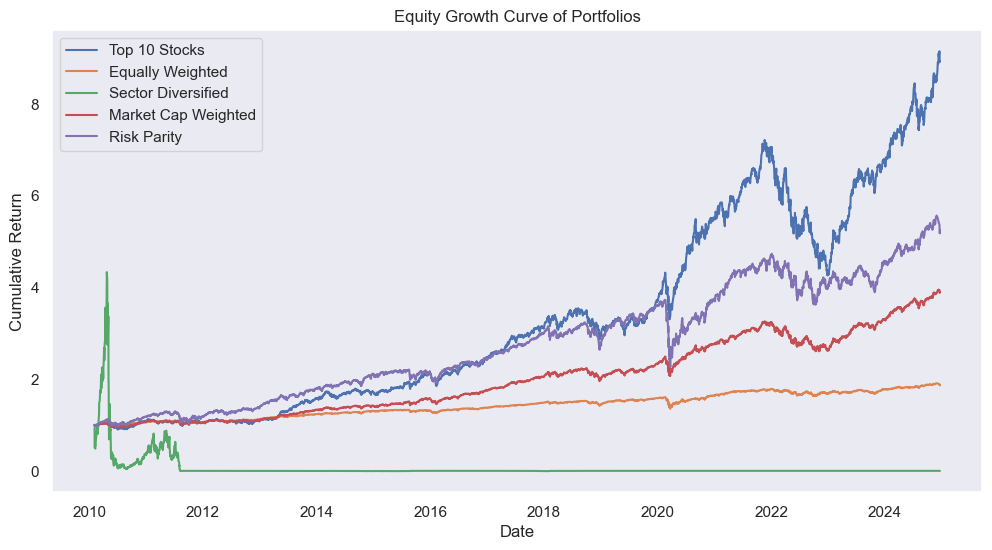

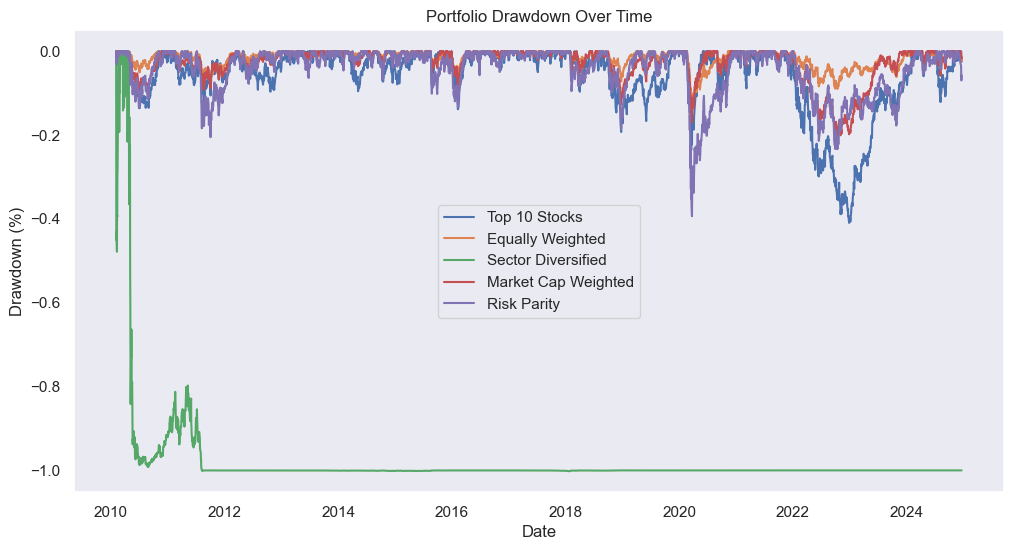

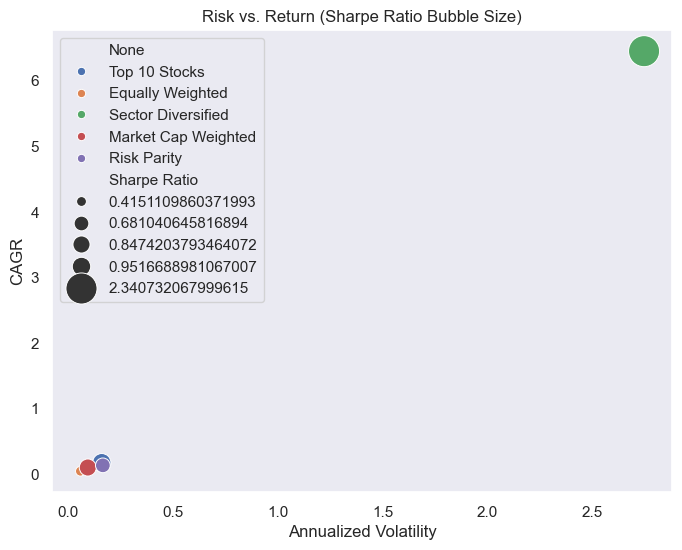

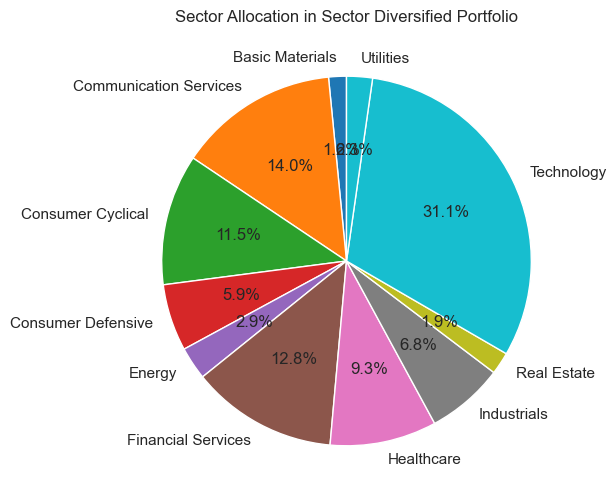

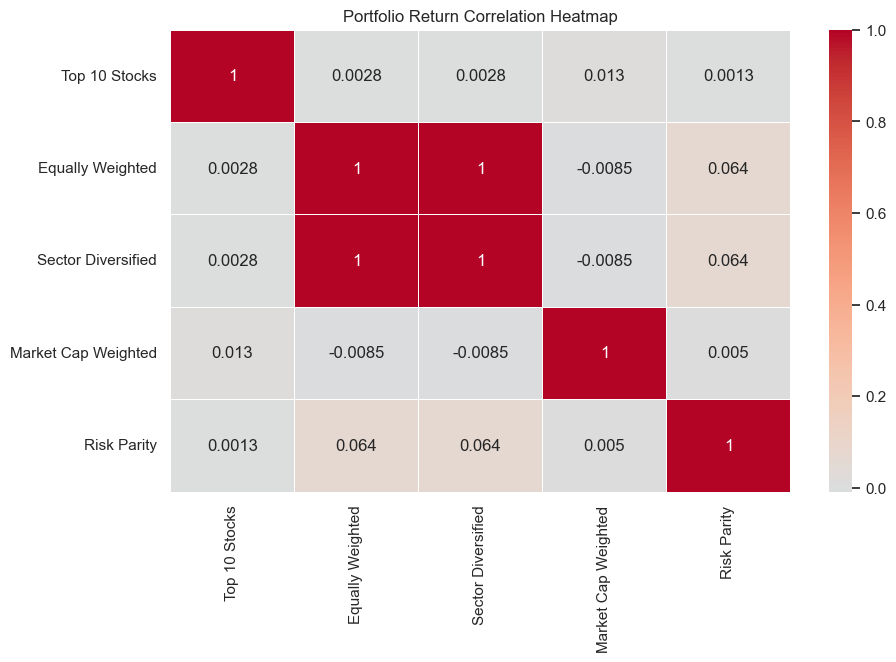

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Equity Growth Curve
plt.figure(figsize=(12, 6))
for name, returns in portfolios.items():
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns, label=name)
plt.title("Equity Growth Curve of Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

# 2️⃣ Drawdown Analysis
plt.figure(figsize=(12, 6))
for name, returns in portfolios.items():
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    plt.plot(drawdown, label=name)
plt.title("Portfolio Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid()
plt.show()

# 3️⃣ Risk-Return Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=performance_metrics['Volatility'],
    y=performance_metrics['CAGR'],
    hue=performance_metrics.index,
    size=performance_metrics['Sharpe Ratio'],
    sizes=(50, 500)
)
plt.title("Risk vs. Return (Sharpe Ratio Bubble Size)")
plt.xlabel("Annualized Volatility")
plt.ylabel("CAGR")
plt.grid()
plt.show()

# 4️⃣ Sector Allocation Over Time (for Sector Diversified Portfolio)
sector_allocations = sp500_companies.groupby('Sector')['Marketcap'].sum()
plt.figure(figsize=(10, 6))
sector_allocations.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab10')
plt.title("Sector Allocation in Sector Diversified Portfolio")
plt.ylabel("")
plt.show()

# 5️⃣ Correlation Heatmap Among Portfolio Strategies
portfolio_returns_df = pd.concat(portfolios.values(), axis=1, keys=portfolios.keys()).pct_change().dropna()
correlation_matrix = portfolio_returns_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Portfolio Return Correlation Heatmap")
plt.show()

## Monte Carlo Simulation

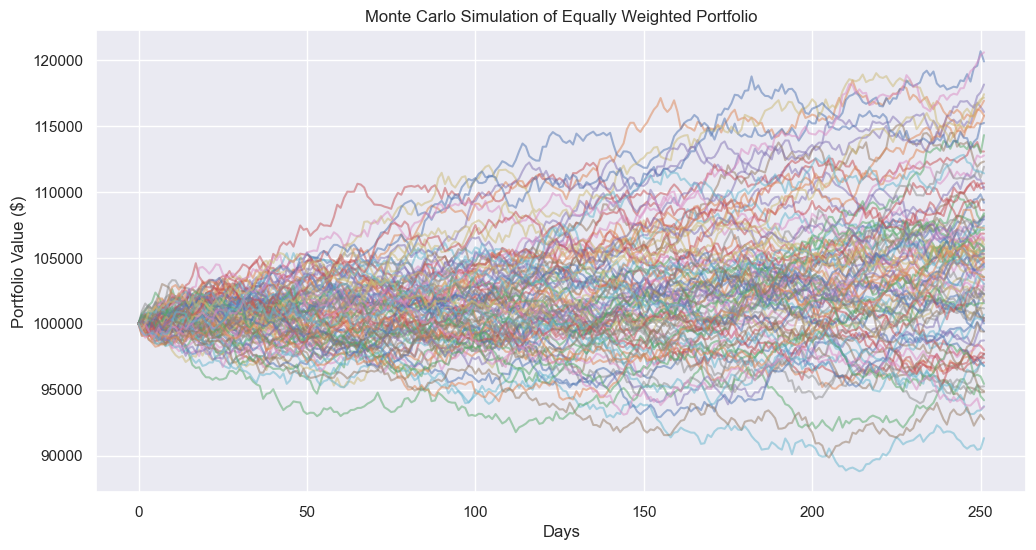

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo Simulation Function (Corrected)
def monte_carlo_simulation(portfolio_returns, num_simulations=100000, T=252, initial_value=100000):
    mu = portfolio_returns.mean() * 252  # Annualized return
    sigma = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility

    # Generate random shocks
    random_shocks = np.random.normal(0, 1, (T, num_simulations))

    # Initialize simulated paths
    simulated_paths = np.zeros((T, num_simulations))
    simulated_paths[0] = initial_value

    for t in range(1, T):
        simulated_paths[t] = simulated_paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) / 252 + sigma * random_shocks[t] / np.sqrt(252))

    return simulated_paths

# Run Monte Carlo for each portfolio (Fix: Removed .pct_change())
monte_carlo_results = {}
for name, returns in portfolios.items():
    monte_carlo_results[name] = monte_carlo_simulation(returns.dropna())

# Plot Monte Carlo Simulations for One Portfolio (Equally Weighted)
plt.figure(figsize=(12, 6))
plt.plot(monte_carlo_results["Equally Weighted"][:, :100], alpha=0.5)  # Show only 10 paths
plt.title("Monte Carlo Simulation of Equally Weighted Portfolio")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.show()

Test market conditions

In [214]:
import numpy as np
import pandas as pd

# Compute log returns for S&P 500 (for consistency with portfolios)
market_returns = np.log(sp500_index['S&P500']).diff().dropna()

# Identify bull and bear markets based on 1-year rolling average of log returns
rolling_market_returns = market_returns.rolling(252).mean()
bull_market = rolling_market_returns.shift(1) > 0  # Use .shift(1) to avoid look-ahead bias
bear_market = rolling_market_returns.shift(1) < 0

# Compute portfolio performance in bull vs. bear markets
bull_bear_performance = pd.DataFrame(columns=portfolios.keys())

for name, returns in portfolios.items():
    returns = returns.dropna()  # Ensure no missing values (log returns)

    # Align portfolio returns with market conditions
    aligned_returns = returns.loc[bull_market.index.intersection(returns.index)]

    # Calculate annualized returns for each market condition
    bull_bear_performance.loc['Bull Market', name] = aligned_returns[bull_market].mean() * 252
    bull_bear_performance.loc['Bear Market', name] = aligned_returns[bear_market].mean() * 252

bull_bear_performance

,Top 10 Stocks,Equally Weighted,Sector Diversified,Market Cap Weighted,Risk Parity
Bull Market,0.186016,0.038572,1.760273,0.104982,0.10729
Bear Market,0.141958,0.054063,2.467246,0.114267,0.151847


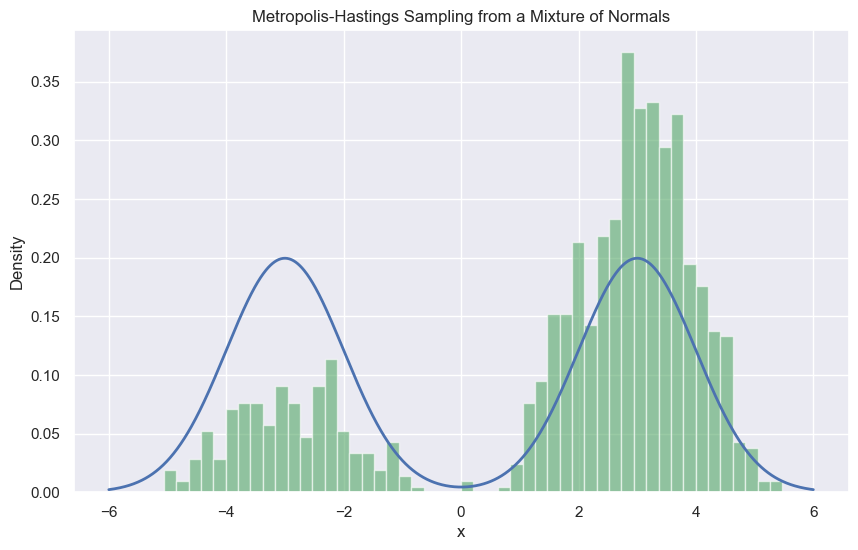

In [254]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution: Mixture of two normal distributions
def target_distribution(x):
    # Parameters for two normal distributions
    mu1, sigma1 = -3, 1
    mu2, sigma2 = 3, 1
    # Mixture of normals
    return 0.5 * (np.exp(-0.5 * ((x - mu1) / sigma1)**2) / (sigma1 * np.sqrt(2 * np.pi))) + \
           0.5 * (np.exp(-0.5 * ((x - mu2) / sigma2)**2) / (sigma2 * np.sqrt(2 * np.pi)))

# Proposal distribution: Gaussian random walk (symmetric)
def proposal_distribution(x, step_size=1):
    return np.random.normal(x, step_size)

# Metropolis-Hastings Algorithm
def metropolis_hastings(target_distribution, proposal_distribution, num_samples, initial_value=0, step_size=1):
    samples = [initial_value]
    current_value = initial_value
    
    for _ in range(num_samples - 1):
        # Propose a new value
        proposed_value = proposal_distribution(current_value, step_size)
        
        # Calculate acceptance ratio
        acceptance_ratio = min(1, target_distribution(proposed_value) / target_distribution(current_value))
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_value = proposed_value
        
        samples.append(current_value)
    
    return np.array(samples)

# Parameters
num_samples = 1000
initial_value = 0
step_size = 1

# Run the Metropolis-Hastings Algorithm
samples = metropolis_hastings(target_distribution, proposal_distribution, num_samples, initial_value, step_size)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
x = np.linspace(-6, 6, 1000)
plt.plot(x, target_distribution(x), color='b', lw=2)
plt.title("Metropolis-Hastings Sampling from a Mixture of Normals")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()